In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml

In [ ]:
# select the experiment for which you want to analyse data
experiment_id = "exp1_gemini_f08df27_20251206_161513" 


### Load the Data

In [9]:
# set the paths
current_folder = globals()['_dh'][0]
results_path = os.path.join(current_folder,f'results/{experiment_id}')
figures_path = os.path.join(current_folder,f'plots')

# read the number of simulations from the config file
with open(os.path.join(results_path, 'config_used.yaml'), "r") as f:
    config = yaml.safe_load(f)
N_SIMS = config['experiment']['n_sims']

# read the results data
iteration_histories = [pd.read_csv(os.path.join(results_path, f'sims/data/iteration_history_{sim+1}.csv'), index_col=0)
                                 for sim in range(N_SIMS)]
agents_histories = [pd.read_csv(os.path.join(results_path, f'sims/data/agent_histories_{sim+1}.csv'), index_col=0)
                    for sim in range(N_SIMS)]

# combine multiple simulations into single dataframes
df_data_all = pd.concat(
    [df.assign(sim=i+1) for i, df in enumerate(iteration_histories)],
    ignore_index=True
)
df_data_agents_all = pd.concat(
    [df.assign(sim=i+1) for i, df in enumerate(agents_histories)],
    ignore_index=True
)

df_transactions_all = df_data_all.loc[df_data_all['transaction']==True].reset_index()


### Plot Transaction Prices

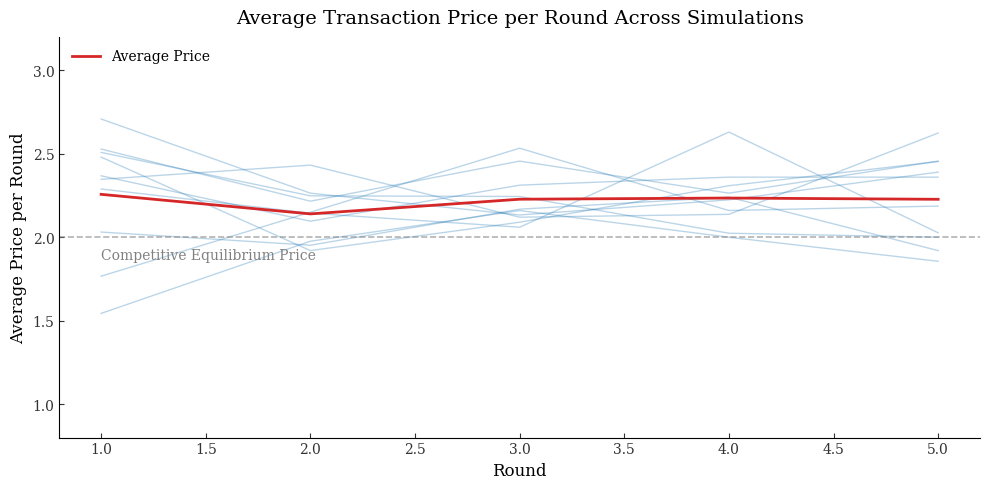

In [10]:
sim_round_avg = df_transactions_all.groupby(['sim', 'round'])['price'].agg(['mean', 'std', 'count']).reset_index()
df_plot = sim_round_avg.pivot_table(index='round', columns='sim', values='mean')
fig, ax = plt.subplots(figsize=(10,5))

# Colors
sim_color = '#1f77b4'  # semi-transparent for individual sims
avg_color = '#d62728'  # bold color for average

# Plot each simulation with light lines
for sim_id in df_plot.columns:
    ax.plot(
        df_plot.index,\
        df_plot[sim_id],
        color=sim_color,
        alpha=0.3,
        linewidth=1
    )

# Plot average across simulations
avg_prices = df_plot.mean(axis=1)
ax.plot(
    df_plot.index,
    avg_prices,
    color=avg_color,
    linewidth=2,
    label='Average Price'
)

# Equilibrium line
ax.axhline(y=2, color='grey', linestyle='--', linewidth=1.2, alpha=0.6)
ax.text(df_plot.index[0], 1.85, 'Competitive Equilibrium Price', color='grey', fontsize=10, family='serif', va='bottom')

# Labels and title
ax.set_xlabel('Round', fontsize=12, family='serif')
ax.set_ylabel('Average Price per Round', fontsize=12, family='serif')
ax.set_title('Average Transaction Price per Round Across Simulations',
             fontsize=14, family='serif', pad=10)

# Tick styling
ax.tick_params(axis='both', direction='in', labelsize=10, colors='#333333')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_family('serif')

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# set the y-axis limit
ax.set_ylim(0.8, 3.2)

# Legend
ax.legend(loc='upper left', frameon=False, prop={'family': 'serif', 'size': 10})

# Disable grid
ax.grid(False)

# Layout and save
fig.tight_layout()
fig.savefig(os.path.join(figures_path, "avg_price_simulations.pdf"))
plt.show()


### Analyse Profits

In [11]:
### Prepare Data Before Plotting ###


# construct an implied profit column for each agents action
df_data_agents_all['implied_profit'] = np.where(
    df_data_agents_all['type'] == 'buyer',
    df_data_agents_all['reservation_price'] - df_data_agents_all['price'],  # buyer profit
    df_data_agents_all['price'] - df_data_agents_all['reservation_price']   # seller profit
)

# filter only the accepted offers
df_profits_realized = df_data_agents_all.loc[df_data_agents_all['outcome']=="accepted"].sort_values(by=["sim", "round", "iteration"]).reset_index(drop=True)

# Calculate profits for buyers and sellers per iteration
df = df_profits_realized.copy()
result = df.pivot_table(
    index=['sim', 'round', 'iteration'],
    columns='type',
    values='implied_profit',
    aggfunc='first'
).reset_index()

# Rename the columns for clarity
result.columns.name = None
result = result.rename(columns={
    'buyer': 'buyer_profit',
    'seller': 'seller_profit'
})

# Add the announcer column
announcer = df[df['action'] == 'announce'].set_index(['sim', 'round', 'iteration'])['type']
df_profits = result.merge(
    announcer.rename('announcer'),
    left_on=['sim', 'round', 'iteration'],
    right_index=True,
    how='left'
)

# calculate announcer vs responder profits
df_profits['announcer_profit'] = np.where(
    df_profits['announcer'] == 'buyer',
    df_profits['buyer_profit'],
    df_profits['seller_profit']
)
df_profits['responder_profit'] = np.where(
    df_profits['announcer'] == 'seller',
    df_profits['buyer_profit'],
    df_profits['seller_profit']
)

In [12]:
# sanity check whether the number of transactions is consistent across data frames
n_transactions = len(df_data_all.loc[df_data_all['transaction']==True])
assert n_transactions == len(df_profits)
print(f"Number of successful transactions: {n_transactions}")

Number of successful transactions: 465


In [13]:
### Print profit statistics across simulations

def compute_stats(df):
    n_transactions = len(df)
    
    announcer_zero = (df['announcer_profit'] == 0).sum() / n_transactions
    responder_zero = (df['responder_profit'] == 0).sum() / n_transactions
    avg_announcer = df['announcer_profit'].mean()
    avg_responder = df['responder_profit'].mean()

    # Define masks for buyers/sellers in this sim
    ann_buyer_mask = df['announcer'] == "buyer"
    ann_seller_mask = df['announcer'] == "seller"

    # Per-announcer-type denominators (only transactions where announcer is that type)
    n_ann_buyer = ann_buyer_mask.sum()
    n_ann_seller = ann_seller_mask.sum()
    
    # By type
    announcer_zero_buy = ((df['announcer_profit']==0) & ann_buyer_mask.loc[df.index]).sum() / n_ann_buyer
    announcer_zero_sell = ((df['announcer_profit']==0) & ann_seller_mask.loc[df.index]).sum() / n_ann_seller
    avg_announcer_buy = df.loc[ann_buyer_mask, 'announcer_profit'].mean()
    avg_announcer_sell = df.loc[ann_seller_mask, 'announcer_profit'].mean()
    
    responder_zero_buy = ((df['responder_profit']==0) & ann_seller_mask.loc[df.index]).sum() / n_ann_seller
    responder_zero_sell = ((df['responder_profit']==0) & ann_buyer_mask.loc[df.index]).sum() / n_ann_buyer
    avg_responder_buy = df.loc[ann_seller_mask, 'responder_profit'].mean()
    avg_responder_sell = df.loc[ann_buyer_mask, 'responder_profit'].mean()
    
    share_buy_announcer = ann_buyer_mask.loc[df.index].sum() / n_transactions
    share_sell_announcer = ann_seller_mask.loc[df.index].sum() / n_transactions
    
    return pd.Series({
        'zero_profit_announcers': announcer_zero,
        'zero_profit_responders': responder_zero,
        'avg_profit_announcers': avg_announcer,
        'avg_profit_responders': avg_responder,
        'zero_profit_announcers_buy': announcer_zero_buy,
        'zero_profit_announcers_sell': announcer_zero_sell,
        'avg_profit_announcers_buy': avg_announcer_buy,
        'avg_profit_announcers_sell': avg_announcer_sell,
        'zero_profit_responders_buy': responder_zero_buy,
        'zero_profit_responders_sell': responder_zero_sell,
        'avg_profit_responders_buy': avg_responder_buy,
        'avg_profit_responders_sell': avg_responder_sell,
        'share_buy_announcers': share_buy_announcer,
        'share_sell_announcers': share_sell_announcer
    })

# Compute stats per simulation
sim_stats = df_profits.groupby('sim').apply(compute_stats, include_groups=False)

# Average across simulations
mean_stats = sim_stats.mean()
std_stats = sim_stats.std()

# Combine mean and std into a formatted string
def format_mean_std(mean_series, std_series):
    formatted = {}
    for col in mean_series.index:
        formatted[col] = f"{mean_series[col]:.2f} ± {std_series[col]:.2f}"
    return pd.Series(formatted)

formatted_stats = format_mean_std(mean_stats, std_stats)

# Print nicely
print("Profit statistics across simulations (mean ± std):\n")
print(f"Share of announcers whose profit is zero: {formatted_stats['zero_profit_announcers']}")
print(f"Share of responders whose profit is zero: {formatted_stats['zero_profit_responders']}")
print(f"Average profit for the announcers: ${formatted_stats['avg_profit_announcers']}")
print(f"Average profit for the responders: ${formatted_stats['avg_profit_responders']}\n")

print(f"Share of buy announcers whose profit is zero: {formatted_stats['zero_profit_announcers_buy']}")
print(f"Share of sell announcers whose profit is zero: {formatted_stats['zero_profit_announcers_sell']}")
print(f"Average profit for announcer buyers: ${formatted_stats['avg_profit_announcers_buy']}")
print(f"Average profit for announcer sellers: ${formatted_stats['avg_profit_announcers_sell']}\n")

print(f"Share of buy responders whose profit is zero: {formatted_stats['zero_profit_responders_buy']}")
print(f"Share of sell responders whose profit is zero: {formatted_stats['zero_profit_responders_sell']}")
print(f"Average profit for responder buyers: ${formatted_stats['avg_profit_responders_buy']}")
print(f"Average profit for responder sellers: ${formatted_stats['avg_profit_responders_sell']}\n")

print(f"Share of buy announcers: {formatted_stats['share_buy_announcers']}")
print(f"Share of sell announcers: {formatted_stats['share_sell_announcers']}")


Profit statistics across simulations (mean ± std):

Share of announcers whose profit is zero: 0.72 ± 0.07
Share of responders whose profit is zero: 0.30 ± 0.08
Average profit for the announcers: $0.21 ± 0.08
Average profit for the responders: $0.42 ± 0.11

Share of buy announcers whose profit is zero: 0.96 ± 0.04
Share of sell announcers whose profit is zero: 0.35 ± 0.12
Average profit for announcer buyers: $0.02 ± 0.04
Average profit for announcer sellers: $0.52 ± 0.14

Share of buy responders whose profit is zero: 0.23 ± 0.15
Share of sell responders whose profit is zero: 0.34 ± 0.07
Average profit for responder buyers: $0.25 ± 0.15
Average profit for responder sellers: $0.54 ± 0.15

Share of buy announcers: 0.61 ± 0.07
Share of sell announcers: 0.39 ± 0.07


### Analyse Announcements and Responses

In [14]:
# prepare the data
df_announcements = df_data_all.groupby(['sim', 'round', 'iteration', 'announcement_type', 'announcing_agent_id'],
                as_index=False, sort=False).agg({
                    'price': 'first',
                    'announcement': 'count',
                    'announcing_agent_reservation_price': 'first',
                    'transaction': 'last'})

df_announcements = df_announcements.rename(columns={'announcement': 'n_responses'})

In [15]:
# Analyse announcements
df = df_announcements.copy()

def compute_announcement_stats(sim_df):
    """Compute announcement statistics for a single simulation"""
    n_buy = (sim_df['announcement_type'] == 'buy').sum()
    n_sell = (sim_df['announcement_type'] == 'sell').sum()
    
    buy_res_price_share = ((sim_df['announcement_type'] == 'buy') &
                            (sim_df['price'] == sim_df['announcing_agent_reservation_price'])).sum() / n_buy
    buy_accepted_share = ((sim_df['announcement_type'] == 'buy') &
                            (sim_df['transaction'] == True)).sum() / n_buy
    
    sell_res_price_share = ((sim_df['announcement_type'] == 'sell') &
                            (sim_df['price'] == sim_df['announcing_agent_reservation_price'])).sum() / n_sell
    sell_accepted_share = ((sim_df['announcement_type'] == 'sell') &
                            (sim_df['transaction'] == True)).sum() / n_sell
    
    return pd.Series({
        'buy_res_price_share': buy_res_price_share,
        'sell_res_price_share': sell_res_price_share,
        'buy_accepted_share': buy_accepted_share,
        'sell_accepted_share': sell_accepted_share
    })

# Compute stats per simulation
sim_stats = df.groupby('sim').apply(compute_announcement_stats, include_groups=False)

# Compute mean and std across simulations
mean_stats = sim_stats.mean()
std_stats = sim_stats.std()
n_obs = sim_stats.count()  # number of simulations contributing to each metric

# Formatting function
def fmt(mean_val, std_val, n):
    if np.isnan(mean_val):
        return "N/A"
    return f"{mean_val:.2f} ± {std_val:.2f} (n={int(n)})"

# Print nicely
print("Announcement statistics across simulations (mean ± std, n = number of simulations with valid data):\n")

print(f"Share of buy announcements equal to the reservation price: {fmt(mean_stats['buy_res_price_share'], std_stats['buy_res_price_share'], n_obs['buy_res_price_share'])}")
print(f"Share of sell announcements equal to the reservation price: {fmt(mean_stats['sell_res_price_share'], std_stats['sell_res_price_share'], n_obs['sell_res_price_share'])}\n")

print(f"Share of buy announcements which were accepted: {fmt(mean_stats['buy_accepted_share'], std_stats['buy_accepted_share'], n_obs['buy_accepted_share'])}")
print(f"Share of sell announcements which were accepted: {fmt(mean_stats['sell_accepted_share'], std_stats['sell_accepted_share'], n_obs['sell_accepted_share'])}")


Announcement statistics across simulations (mean ± std, n = number of simulations with valid data):

Share of buy announcements equal to the reservation price: 0.92 ± 0.05 (n=10)
Share of sell announcements equal to the reservation price: 0.30 ± 0.09 (n=10)

Share of buy announcements which were accepted: 0.76 ± 0.09 (n=10)
Share of sell announcements which were accepted: 0.41 ± 0.14 (n=10)


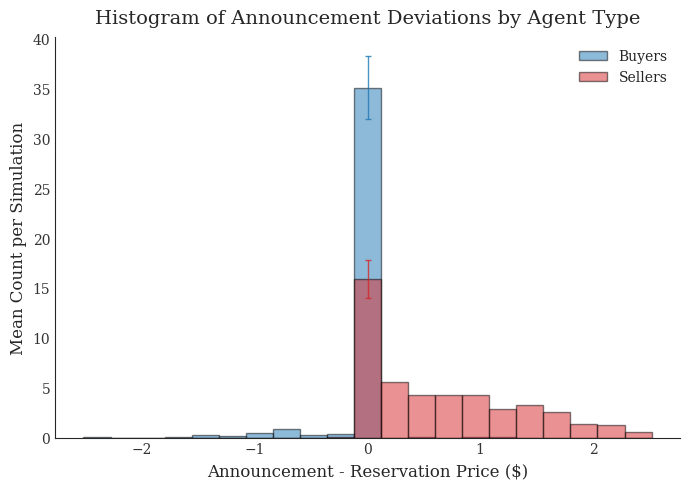

In [16]:
# Plot the distribution of announcement deviation from reservation price with 

# Copy data and compute deviation
df_plot = df_announcements.copy()
df_plot['deviation'] = df_plot['price'] - df_plot['announcing_agent_reservation_price']

# prepare a mask for buyers and sellers
buy_mask = df_plot['announcement_type'] == "buy"
sell_mask = df_plot['announcement_type'] == "sell"

# Define bins symmetric around zero
max_dev = np.max(np.abs(df_plot['deviation']))
num_bins = 20
bin_width = (2 * max_dev) / num_bins
bins = np.arange(-max_dev - bin_width/2, max_dev + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Function to compute mean & CI across simulations
def compute_hist_ci(data, mask, value_col, bins):
    sims = data['sim'].unique()
    counts_per_sim = []
    for sim_id in sims:
        vals = data.loc[(data['sim'] == sim_id) & mask, value_col]
        counts, _ = np.histogram(vals, bins=bins, density=False)
        counts_per_sim.append(counts)
    counts_per_sim = np.array(counts_per_sim)
    mean_counts = counts_per_sim.mean(axis=0)
    se = counts_per_sim.std(axis=0, ddof=1) / np.sqrt(len(sims))
    ci95 = 1.96 * se
    return mean_counts, ci95

# Compute buyers and sellers histograms + CIs
buyers_mean, buyers_ci = compute_hist_ci(df_plot, buy_mask, 'deviation', bins)
sellers_mean, sellers_ci = compute_hist_ci(df_plot, sell_mask, 'deviation', bins)

# Find the index of the 0 bin
zero_bin_idx = np.argmin(np.abs(bin_centers))

# --- Plot ---
sns.set_style("white")
fig, ax = plt.subplots(figsize=(7,5))

# Buyers (full-width bars)
ax.bar(
    bin_centers, buyers_mean,
    width=bin_width, color='#1f77b4', alpha=0.5,
    edgecolor='k', label='Buyers'
)

# Sellers (full-width bars)
ax.bar(
    bin_centers, sellers_mean,
    width=bin_width, color='#d62728', alpha=0.5,
    edgecolor='k', label='Sellers'
)

# Draw CI only for the 0 bin
ax.errorbar(
    bin_centers[zero_bin_idx], buyers_mean[zero_bin_idx], yerr=buyers_ci[zero_bin_idx],
    fmt='none', ecolor='#1f77b4', elinewidth=1, capsize=2, alpha=0.8
)
ax.errorbar(
    bin_centers[zero_bin_idx], sellers_mean[zero_bin_idx], yerr=sellers_ci[zero_bin_idx],
    fmt='none', ecolor='#d62728', elinewidth=1, capsize=2, alpha=0.8
)

# Optional zero line
# ax.axvline(0, color='k', linestyle='--', linewidth=1)

# Axis labels and title
ax.set_xlabel("Announcement - Reservation Price ($)", fontsize=12, family='serif')
ax.set_ylabel("Mean Count per Simulation", fontsize=12, family='serif')
ax.set_title("Histogram of Announcement Deviations by Agent Type",
             fontsize=14, family='serif', pad=10)

# Tick styling
ax.tick_params(axis='both', direction='in', labelsize=10, colors='#333333')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_family('serif')

# Spines and legend
for side in ['top', 'right']:
    ax.spines[side].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.legend(loc='upper right', frameon=False, prop={'family': 'serif', 'size': 10})

ax.grid(False)
fig.tight_layout()
fig.savefig(os.path.join(figures_path, "announcement_deviation.pdf"))
plt.show()


### Profit Charts

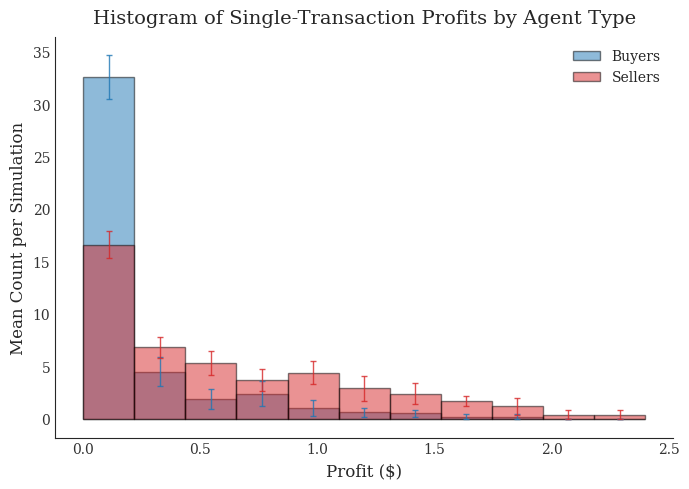

In [17]:
# Histogram of Single Transaction Profits by agent type
# with 95%-CIs
# overlapping bars

# --- Define bins ---
min_profit = df_profits[['buyer_profit','seller_profit']].min().min()
max_profit = df_profits[['buyer_profit','seller_profit']].max().max()

# Negative, zero, then positive bins
positive_bins = np.linspace(0, max_profit, 12)
bins = np.concatenate(([0], positive_bins[1:]))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_width = np.diff(bins)

# --- Compute mean & CI per simulation ---
def hist_with_ci(data, value_col):
    sims = data['sim'].unique()
    counts_per_sim = []
    for sim_id in sims:
        vals = data.loc[data['sim'] == sim_id, value_col]
        counts, _ = np.histogram(vals, bins=bins, density=False)
        counts_per_sim.append(counts)
    counts_per_sim = np.array(counts_per_sim)
    mean_counts = counts_per_sim.mean(axis=0)
    se = counts_per_sim.std(axis=0, ddof=1) / np.sqrt(len(sims))
    ci95 = 1.96 * se
    return mean_counts, ci95

buyers_mean, buyers_ci = hist_with_ci(df_profits, 'buyer_profit')
sellers_mean, sellers_ci = hist_with_ci(df_profits, 'seller_profit')

# --- Plot ---
sns.set_style("white")
fig, ax = plt.subplots(figsize=(7,5))

# Buyers (blue)
ax.bar(
    bin_centers, buyers_mean,
    width=bin_width, color='#1f77b4', alpha=0.5,
    edgecolor='k', label='Buyers'
)
ax.errorbar(
    bin_centers, buyers_mean,
    yerr=buyers_ci, fmt='none', ecolor='#1f77b4',
    elinewidth=1, capsize=2, alpha=0.8
)

# Sellers (red)
ax.bar(
    bin_centers, sellers_mean,
    width=bin_width, color='#d62728', alpha=0.5,
    edgecolor='k', label='Sellers'
)
ax.errorbar(
    bin_centers, sellers_mean,
    yerr=sellers_ci, fmt='none', ecolor='#d62728',
    elinewidth=1, capsize=2, alpha=0.8
)

# Labels and title
ax.set_xlabel("Profit ($)", fontsize=12, family='serif')
ax.set_ylabel("Mean Count per Simulation", fontsize=12, family='serif')
ax.set_title("Histogram of Single-Transaction Profits by Agent Type",
             fontsize=14, family='serif', pad=10)

# Tick styling
ax.tick_params(axis='both', direction='in', labelsize=10, colors='#333333')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_family('serif')

# Spines and legend
for side in ['top', 'right']:
    ax.spines[side].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.legend(loc='upper right', frameon=False, prop={'family': 'serif', 'size':10})

ax.grid(False)
fig.tight_layout()
fig.savefig(os.path.join(figures_path, "profit_distribution.pdf"))
plt.show()


### Plot Demand and Supply Curves

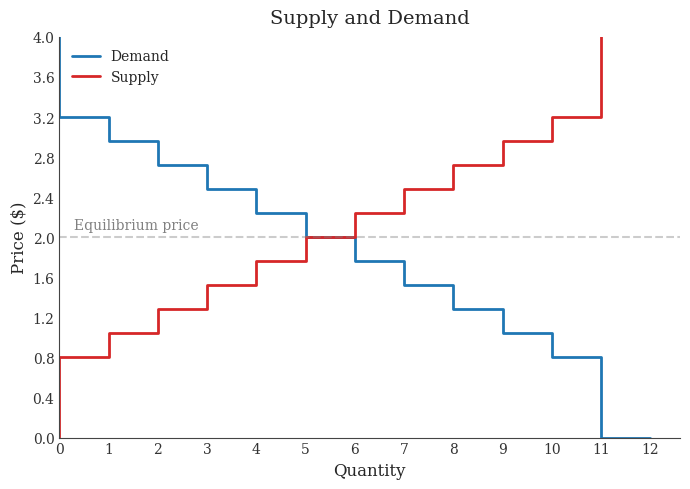

In [18]:
# Plot the Demand and Supply Curves from the reservation prices of agents

bp = config['experiment']['buyers_reservation_prices']
sp = config['experiment']['sellers_reservation_prices']

demand_p = np.round(np.linspace(bp["max"], bp["min"], bp["num"]), 2)
supply_p = np.round(np.linspace(bp["min"], bp["max"], bp["num"]), 2)

demand_q = np.arange(1, bp['num'] + 1)
supply_q = np.arange(1, sp['num'] + 1)

# Extend curves
demand_q_ext = np.concatenate(([0], demand_q, [demand_q[-1] + 1]))
demand_p_ext = np.concatenate(([999], demand_p, [0]))
supply_q_ext = np.concatenate(([0], supply_q, [supply_q[-1] + 1]))
supply_p_ext = np.concatenate(([0], supply_p, [999]))

# === Plot ===
fig, ax = plt.subplots(figsize=(7, 5))

# Step lines
ax.step(demand_q_ext, demand_p_ext, where='pre', label='Demand', color='#1f77b4', linewidth=2)
ax.step(supply_q_ext, supply_p_ext, where='pre', label='Supply', color='#d62728', linewidth=2)

# Axis labels and title
ax.set_xlabel('Quantity', fontsize=12, family='serif')
ax.set_ylabel('Price ($)', fontsize=12, family='serif')
ax.set_title('Supply and Demand', fontsize=14, family='serif', pad=10)

# Axis limits and ticks
ax.set_xlim(left=0)
ax.set_ylim(0, 4)
ax.set_xticks(supply_q_ext)
ax.set_yticks(np.arange(0, 4.1, 0.4))

# Subtle grid
# ax.grid(True, which='major', linestyle=':', linewidth=0.5, alpha=0.5)
ax.grid(False)

# Equilibrium line
ax.axhline(y=2, color='grey', linestyle='--', alpha=0.4)
ax.text(0.3, 2.05, 'Equilibrium price', color='grey', fontsize=10, va='bottom', family='serif')

# Axes positioning
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick style
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#444444')
    ax.spines[spine].set_linewidth(0.8)

ax.tick_params(axis='both', direction='in', colors='#333333', labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_family('serif')

# Legend
ax.legend(loc='upper left', frameon=False, prop={'family': 'serif', 'size': 10})

# Save + show
fig.tight_layout()
fig.savefig(os.path.join(figures_path, "supply_demand_diagram.pdf"))
plt.show()


### Analyse Responses

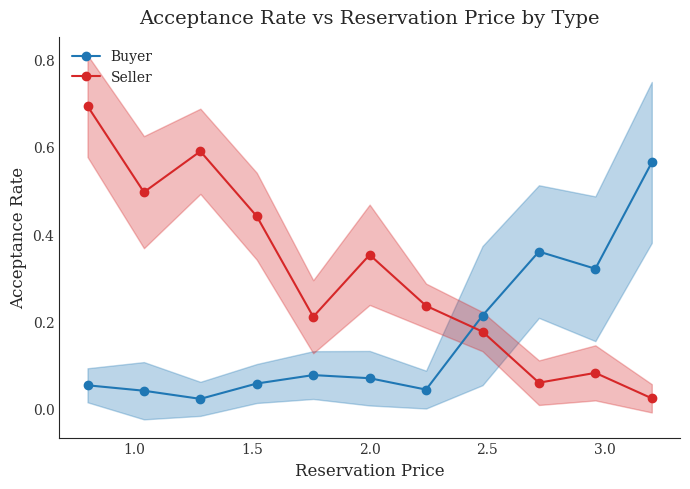

In [19]:
# Plot Acceptance Rate vs Reservation Price with 95% CIs

# --- Prepare Data ---
df = df_data_agents_all.loc[df_data_agents_all['action']=='respond']
df = df.groupby(['sim', 'type', 'id', 'reservation_price', 'outcome']).agg({
    'price': 'count'
}
).reset_index()
df = df.pivot(index=['sim', 'type', 'id', 'reservation_price'], 
                   columns='outcome',
                   values='price').fillna(0)
df['total'] = df['accepted'] + df['rejected']

df['acceptance_rate'] = df['accepted']/df['total']
df = df.reset_index()

# --- Aggregate over simulations ---
agg = df.groupby(['type', 'reservation_price']).agg(
    mean_rate=('acceptance_rate', 'mean'),
    se=('acceptance_rate', lambda x: x.std(ddof=1)/np.sqrt(len(x)))
).reset_index()
agg['ci95'] = 1.96 * agg['se']

# --- Plot ---
sns.set_style("white")
fig, ax = plt.subplots(figsize=(7,5))

types = agg['type'].unique()
colors = {'buyer': '#1f77b4', 'seller': '#d62728'}

for t in types:
    df_t = agg[agg['type'] == t]
    ax.plot(df_t['reservation_price'], df_t['mean_rate'],
            marker='o', color=colors[t], label=t.capitalize())
    ax.fill_between(df_t['reservation_price'],
                    df_t['mean_rate'] - df_t['ci95'],
                    df_t['mean_rate'] + df_t['ci95'],
                    color=colors[t], alpha=0.3)

# Labels and title
ax.set_xlabel("Reservation Price", fontsize=12, family='serif')
ax.set_ylabel("Acceptance Rate", fontsize=12, family='serif')
ax.set_title("Acceptance Rate vs Reservation Price by Type",
             fontsize=14, family='serif', pad=10)

# Tick styling
ax.tick_params(axis='both', direction='in', labelsize=10, colors='#333333')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_family('serif')

# Spines and legend
for side in ['top', 'right']:
    ax.spines[side].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.legend(loc='upper left', frameon=False, prop={'family': 'serif', 'size':10})

ax.grid(False)
fig.tight_layout()
plt.show()
